## 🔧 Part 1: Environment Setup

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: /Users/nazhimkalam/.pyenv/versions/evat_env_py310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 29.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 22.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: /Users/nazhimkalam/.pyenv/versions/evat_env_py310/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---

## Data Exploration & Preprocessing
### 1.1 Load & Inspect Dataset

**Step 1 — Import dataset**
- Reads the raw CSV file: `station_data_dataverse.csv`.  
- Contains **3,395 rows × 24 columns** initially.  
- Columns include session details like `sessionId`, `kwhTotal`, `dollars`, `created`, `ended`, `stationId`, `chargeTimeHrs`, etc.  

---

**Step 2 — Initial checks**
- `df.shape` confirms dataset size (3395, 24).  
- `df.head(3)` shows first few rows for a quick look.  
- Columns `created` and `ended` store timestamps of when each charging session began and ended.  

---

**Step 3 — Detecting year errors**
- Preview of `created` column shows issues: years like `0014` or `0015` instead of `2014` or `2015`.  
- This is a **data quality issue** that needs fixing.  

---

**Step 4 — Extract year parts**
- Created a new column `created_year_part` by taking the first 4 characters of the timestamp string.  
- Counts show:
  - `0014` → 23 rows  
  - `0015` → 3372 rows  
- Confirms that many years are incorrectly stored.  

---

**Step 5 — Cleaning year prefixes**
- Replaced `^0014` → `2014`  
- Replaced `^0015` → `2015`  
- Applied corrections to both `created` and `ended` columns.  

---

**Step 6 — Convert to datetime**
- Converted `created` and `ended` columns into proper `datetime` objects.  
- Dropped rows with missing values in these columns.  

---

**Step 7 — Final cleaned dataset**
- Shape after cleaning: **3,395 rows × 25 columns**.  
- Confirmed valid date range:  
  - **Min created:** 2014-11-18  
  - **Max ended:** 2015-10-04  

---

✅ **Purpose of this step:**  
- To ensure **timestamps are correct and consistent**, because time-based features (arrivals, lags, rolling averages, queues) all depend on valid datetime values.  
- Fixing wrong years was critical before any modeling or aggregation could happen.  


### 1.1 Load & Inspect Dataset

In [104]:
import pandas as pd

df = pd.read_csv('station_data_dataverse.csv', low_memory=False)
print(df.columns)

Index(['sessionId', 'kwhTotal', 'dollars', 'created', 'ended', 'startTime',
       'endTime', 'chargeTimeHrs', 'weekday', 'platform', 'distance', 'userId',
       'stationId', 'locationId', 'managerVehicle', 'facilityType', 'Mon',
       'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'reportedZip'],
      dtype='object')


In [105]:
df.shape

(3395, 24)

In [106]:
df.head(3)

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,managerVehicle,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip
0,1366563,7.78,0.00,0014-11-18 15:40:26,0014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,3,0,1,0,0,0,0,0,0
1,3075723,9.74,0.00,0014-11-19 17:40:26,0014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,3,0,0,1,0,0,0,0,0
2,4228788,6.76,0.58,0014-11-21 12:05:46,0014-11-21 16:46:04,12,16,4.671667,Fri,android,...,0,3,0,0,0,0,1,0,0,0


In [107]:
print(df['created'].head(10).tolist())
print(df['ended'].head(10).tolist())

['0014-11-18 15:40:26', '0014-11-19 17:40:26', '0014-11-21 12:05:46', '0014-12-03 19:16:12', '0014-12-11 20:56:11', '0014-12-12 14:38:44', '0014-12-12 15:08:40', '0014-12-17 20:30:25', '0014-12-18 17:53:19', '0014-12-18 18:06:49']
['0014-11-18 17:11:04', '0014-11-19 19:51:04', '0014-11-21 16:46:04', '0014-12-03 21:02:18', '0014-12-11 21:14:06', '0014-12-12 15:04:04', '0014-12-12 15:47:04', '0014-12-17 21:31:04', '0014-12-18 18:04:04', '0014-12-18 18:30:05']


In [108]:
# Just get the first 4 characters (year parts)
df['created_year_part'] = df['created'].str[:4]
print(df['created_year_part'].value_counts())


created_year_part
0015    3372
0014      23
Name: count, dtype: int64


In [109]:
print(df['created'].sample(10).tolist())

['0015-08-11 13:08:06', '0015-07-27 11:19:51', '0015-07-24 11:22:20', '0015-04-15 17:31:15', '0014-11-25 16:57:46', '0015-02-23 17:40:15', '0015-05-29 10:39:26', '0015-07-23 12:48:39', '0015-06-01 16:21:57', '0015-03-17 17:36:15']


In [110]:
# Correct the year prefix in both columns
df['created'] = df['created'].str.replace(r'^0014', '2014', regex=True)
df['created'] = df['created'].str.replace(r'^0015', '2015', regex=True)

df['ended'] = df['ended'].str.replace(r'^0014', '2014', regex=True)
df['ended'] = df['ended'].str.replace(r'^0015', '2015', regex=True)

# Convert to datetime
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df['ended'] = pd.to_datetime(df['ended'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['created', 'ended'])
print("Final cleaned shape:", df.shape)


Final cleaned shape: (3395, 25)


In [111]:
df.shape

(3395, 25)

In [112]:
print("Min created:", df['created'].min())
print("Max ended:", df['ended'].max())

Min created: 2014-11-18 15:01:17
Max ended: 2015-10-04 15:54:06


In [113]:
df.head()

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,facilityType,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip,created_year_part
0,1366563,7.78,0.00,2014-11-18 15:40:26,2014-11-18 17:11:04,15,17,1.510556,Tue,android,...,3,0,1,0,0,0,0,0,0,0014
1,3075723,9.74,0.00,2014-11-19 17:40:26,2014-11-19 19:51:04,17,19,2.177222,Wed,android,...,3,0,0,1,0,0,0,0,0,0014
2,4228788,6.76,0.58,2014-11-21 12:05:46,2014-11-21 16:46:04,12,16,4.671667,Fri,android,...,3,0,0,0,0,1,0,0,0,0014
3,3173284,6.17,0.00,2014-12-03 19:16:12,2014-12-03 21:02:18,19,21,1.768333,Wed,android,...,3,0,0,1,0,0,0,0,0,0014
4,3266500,0.93,0.00,2014-12-11 20:56:11,2014-12-11 21:14:06,20,21,0.298611,Thu,android,...,3,0,0,0,1,0,0,0,0,0014


### 1.2 Convert Columns to Datetime
- Columns `created` (start time) and `ended` (end time) need to be converted into proper datetime format.
- `errors="coerce"` is used:
  - If an invalid date exists, it becomes `NaT` (missing value) instead of breaking the code.
- This ensures time-based analysis (e.g., durations, bins) can be performed correctly.


In [114]:
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df['ended'] = pd.to_datetime(df['ended'], errors='coerce')

### 1.3 Data Cleaning
- **Drop rows** where `created` or `ended` is missing.
- Keep only valid sessions where `ended > created`.
- This step ensures no invalid or reversed timestamps exist.
- Final valid date range: **Nov 2014 → Oct 2015**.

In [115]:
df = df.dropna(subset=['created', 'ended'])
df = df[df['ended'] > df['created']]

In [116]:
print("Valid date range:")
print("Start:", df['created'].min())
print("End:", df['ended'].max())

Valid date range:
Start: 2014-11-18 15:01:17
End: 2015-10-04 15:54:06


In [117]:
df.count()

sessionId            3395
kwhTotal             3395
dollars              3395
created              3395
ended                3395
startTime            3395
endTime              3395
chargeTimeHrs        3395
weekday              3395
platform             3395
distance             2330
userId               3395
stationId            3395
locationId           3395
managerVehicle       3395
facilityType         3395
Mon                  3395
Tues                 3395
Wed                  3395
Thurs                3395
Fri                  3395
Sat                  3395
Sun                  3395
reportedZip          3395
created_year_part    3395
dtype: int64

### 1.4 Creating a Charging Duration Feature
- A new column `charge_duration_hrs` is created:
  \[
  \text{charge_duration_hrs} = \frac{ended - created}{3600 \text{ seconds}}
  \]
- This gives session lengths in hours, which is important for queueing theory and service rate estimation.

- Additional time features:
  - `created_hour`: Hour of the day when session started.
  - `ended_hour`: Hour of the day when session ended.
- `startTime` and `endTime` columns are dropped after extracting the useful parts.


In [118]:
df['charge_duration_hrs'] = (df['ended'] - df['created']).dt.total_seconds() / 3600

In [119]:
df.head(2)

,sessionId,kwhTotal,dollars,created,ended,startTime,endTime,chargeTimeHrs,weekday,platform,...,Mon,Tues,Wed,Thurs,Fri,Sat,Sun,reportedZip,created_year_part,charge_duration_hrs
0,1366563,7.78,0.0,2014-11-18 15:40:26,2014-11-18 17:11:04,15,17,1.510556,Tue,android,...,0,1,0,0,0,0,0,0,0014,1.510556
1,3075723,9.74,0.0,2014-11-19 17:40:26,2014-11-19 19:51:04,17,19,2.177222,Wed,android,...,0,0,1,0,0,0,0,0,0014,2.177222


In [120]:
df['created_hour'] = df['created'].dt.hour
df['ended_hour'] = df['ended'].dt.hour

df.drop(columns=['startTime', 'endTime'], inplace=True)

In [121]:
df.head(2)

,sessionId,kwhTotal,dollars,created,ended,chargeTimeHrs,weekday,platform,distance,userId,...,Wed,Thurs,Fri,Sat,Sun,reportedZip,created_year_part,charge_duration_hrs,created_hour,ended_hour
0,1366563,7.78,0.0,2014-11-18 15:40:26,2014-11-18 17:11:04,1.510556,Tue,android,NaN,35897499,...,0,0,0,0,0,0,0014,1.510556,15,17
1,3075723,9.74,0.0,2014-11-19 17:40:26,2014-11-19 19:51:04,2.177222,Wed,android,NaN,35897499,...,1,0,0,0,0,0,0014,2.177222,17,19


### 1.5 Remove Sessions with Unrealistic Durations
- Sessions with:
  - **duration <= 0 hours** (invalid)
  - **duration > 12 hours** (likely outliers/unrealistic)
- These are filtered out.
- Example: A session with duration **55 hours** was removed.
- Remaining dataset size: **3394 rows**.


In [122]:
# Identify bad sessions: duration <= 0 or > 12 hours
bad_sessions = df[(df['charge_duration_hrs'] <= 0) | (df['charge_duration_hrs'] > 12)]

# Print them for inspection
print("Sessions removed due to invalid duration:")
print(bad_sessions[['sessionId', 'created', 'ended', 'charge_duration_hrs']])

# Now filter them out from the main DataFrame
df = df[(df['charge_duration_hrs'] > 0) & (df['charge_duration_hrs'] <= 12)]

print("Remaining rows after filtering:", df.shape)

Sessions removed due to invalid duration:
     sessionId             created               ended  charge_duration_hrs
173    2162299 2015-01-26 18:09:47 2015-01-29 01:24:04            55.238056
Remaining rows after filtering: (3394, 26)


---
## 1.6 Histogram of Sessions Per Station

### Purpose
This step checks how many charging sessions are recorded at each station.  
It helps identify:
- **Busy stations** (with many sessions).
- **Sparse stations** (with very few sessions, which may not provide enough data for reliable modeling).

### What the Code Does
1. Counts the number of sessions for each station (`stationId`).
2. Creates a histogram with 30 bins to show the **distribution of session counts** across all stations.
3. Adds labels and titles for clear visualization.

### Insights from the Histogram
- Most stations have **very few sessions** (less than 50).
- A few stations are much busier, with over 100 sessions.
- This imbalance indicates that:
  - Busy stations will dominate the data.
  - Sparse stations may introduce noise and make it harder for the model to learn patterns.
  - Care must be taken (e.g., filtering out extremely sparse stations or applying normalization).

### Why It’s Important
- Identifies **data imbalance** across stations.
- Helps decide if low-activity stations should be included, dropped, or handled differently.
- Ensures that predictions (e.g., arrivals, wait times) aren’t biased by stations with very few data points.


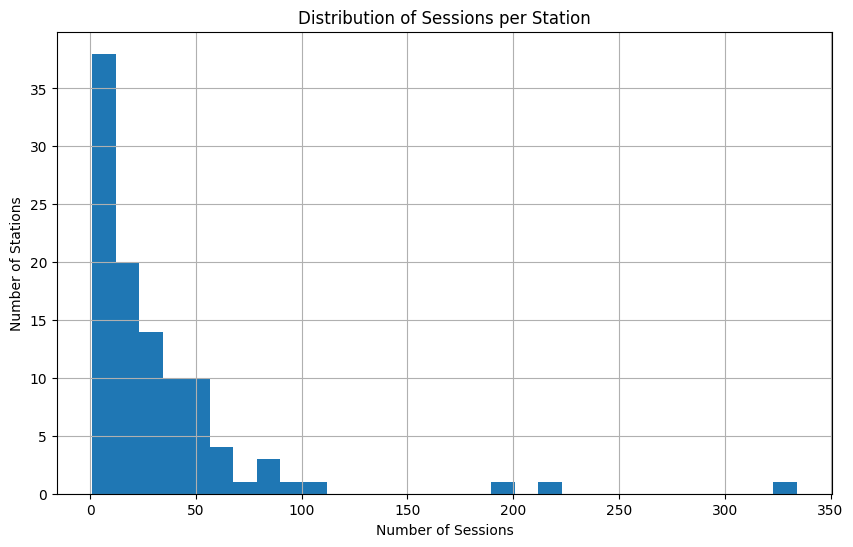

In [124]:
import matplotlib.pyplot as plt

station_counts = df['stationId'].value_counts()

plt.figure(figsize=(10, 6))
station_counts.hist(bins=30)
plt.title('Distribution of Sessions per Station')
plt.xlabel('Number of Sessions')
plt.ylabel('Number of Stations')
plt.grid(True)
plt.show()

## 1.7 Top 10 Busiest Stations

### Purpose
This step identifies the **stations with the highest number of charging sessions**.  
It helps us focus on the busiest locations where congestion and waiting times are more likely to occur.

### What the Code Does
1. Takes the session counts for all stations (from the previous histogram).
2. Selects the **top 10 stations** with the most sessions.
3. Plots a **bar chart** showing each station’s ID and total number of sessions.

### Insights from the Plot
- **Station 369001** is the busiest, with over 300 sessions.
- The next two stations (414204 and 955429) also show high usage (150–200 sessions).
- Remaining stations have lower but still notable activity.
- There’s a **long-tail distribution**: only a few stations are heavily used, while most have low usage.

### Why It’s Important
- Helps us **prioritize modeling and analysis** on high-demand stations (where predictions matter most).
- Busiest stations are the most critical for:
  - **Congestion prediction**
  - **Queueing theory analysis** (wait times, utilization, etc.)
  - **Policy recommendations** (where to add more chargers).
- Sparse stations may not provide strong patterns, but **busy stations define system performance**.



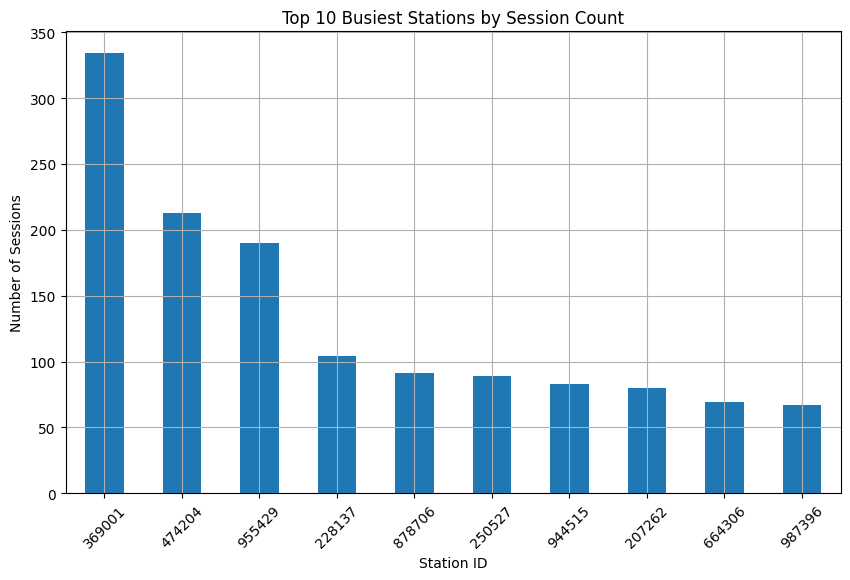

In [125]:
top10 = station_counts.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='bar')
plt.title('Top 10 Busiest Stations by Session Count')
plt.xlabel('Station ID')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 1.8 Time Range per Station (Operational Span)

### Purpose
This analysis measures how long each station was active in the dataset.  
By calculating the **difference between the first (`min`) and last (`max`) recorded session**, we estimate each station’s **operational span (days of activity)**.

### What the Code Does
1. Groups the dataset by `stationId`.
2. Finds the **earliest (`min`)** and **latest (`max`)** session timestamp for each station.
3. Computes the **duration in days** = (`max` - `min`).
4. Sorts stations by operational span and plots the **Top 10 stations**.

### Insights from the Plot
- Many stations were active for **almost the full study period (~300+ days)**.
- Stations like **582873, 129465, 549414** show the longest operational spans.
- Unlike “busiest stations” (measured by count of sessions), these are stations that were **consistently available over time**.
- Some stations may have fewer total sessions but still a **long operational span** — meaning low but steady usage.

### Why It’s Important
- Provides **temporal coverage** context: we can trust stations with longer operational spans for modeling trends.
- Ensures fairness when comparing stations:
  - A station with high sessions but short operational time may not be directly comparable to a long-operating station.
- Helps identify **stable stations** vs. those with **limited availability**.



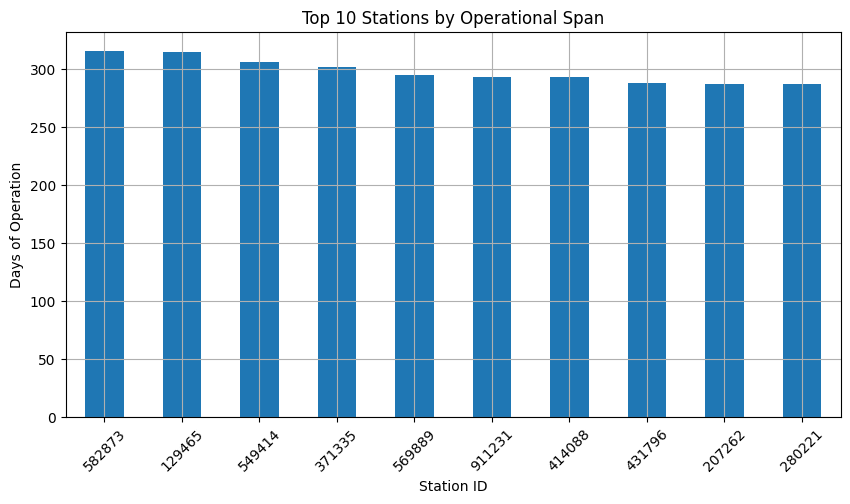

In [126]:
time_range = df.groupby('stationId')['created'].agg(['min', 'max'])
time_range['duration_days'] = (time_range['max'] - time_range['min']).dt.days
time_range = time_range.sort_values(by='duration_days', ascending=False).head(10)

time_range['duration_days'].plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Stations by Operational Span')
plt.ylabel('Days of Operation')
plt.xlabel('Station ID')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 1.9 Heatmap of Sessions by Hour of Day (Top 10 Stations)

### Purpose
This visualization explores **when charging activity happens during the day** across the busiest stations.  
By grouping sessions by `stationId` and `hour of creation`, we highlight **daily usage patterns**.

### What the Code Does
1. Extracts the **hour** from the `created` timestamp.
2. Groups data by `(stationId, created_hour)` to count sessions.
3. Builds a **heatmap** (hours on x-axis, stations on y-axis) showing how many sessions occur at each hour.

### Insights from the Heatmap
- **Peak usage occurs between 9 AM – 6 PM**, aligning with work hours and daytime travel.
- Station **228137** shows a sharp morning peak around **9–10 AM**.
- Other stations (e.g., 219054, 207262) have **more evenly spread activity**, though still concentrated in daylight hours.
- Very few sessions occur during the **late night (0–5 AM)** — confirming low demand at night.

### Why It’s Important
- Identifies **high-demand hours** → useful for **capacity planning** and **dynamic pricing**.
- Confirms that congestion and waiting times are more likely during the **daytime peaks**.
- Highlights station-level differences: some stations have sharp peaks (office/commuter hubs), while others have steady demand (residential or mixed-use areas).



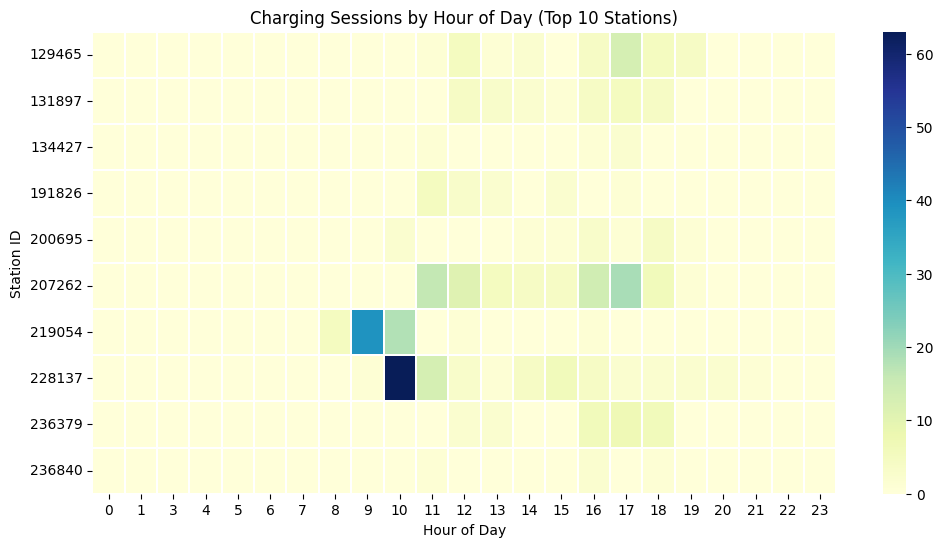

In [127]:
import seaborn as sns

df['created_hour'] = df['created'].dt.hour
hourly_counts = df.groupby(['stationId', 'created_hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(hourly_counts.head(10), cmap='YlGnBu', linewidths=0.3)
plt.title('Charging Sessions by Hour of Day (Top 10 Stations)')
plt.xlabel('Hour of Day')
plt.ylabel('Station ID')
plt.show()

### Filtering stations with > 100 sessions

In [128]:
# Filter stations with > 100 sessions
station_counts = df['stationId'].value_counts()
active_stations = station_counts[station_counts > 100].index
df = df[df['stationId'].isin(active_stations)]

print("Filtered data shape:", df.shape)
print("Remaining stations:", df['stationId'].nunique())


Filtered data shape: (841, 26)
Remaining stations: 4


### Sorting the dataset based on stationID and created

In [129]:
df = df.sort_values(by=['stationId', 'created'])

### Confirm Station ID is a clean column

In [130]:
df['stationId'] = df['stationId'].astype(str)

### Ensure sessionId is unique

In [133]:
assert df['sessionId'].is_unique, "Duplicate session IDs found!"

### View cleaned dataset

In [134]:
df

,sessionId,kwhTotal,dollars,created,ended,chargeTimeHrs,weekday,platform,distance,userId,...,Wed,Thurs,Fri,Sat,Sun,reportedZip,created_year_part,charge_duration_hrs,created_hour,ended_hour
1870,6748253,6.49,1.33,2015-03-17 13:06:58,2015-03-17 18:30:10,5.386667,Tue,ios,19.103700,32015313,...,0,0,0,0,0,1,0015,5.386667,13,18
1879,7882118,0.00,0.00,2015-03-24 18:10:46,2015-03-24 18:12:05,0.021944,Tue,ios,NaN,92192265,...,0,0,0,0,0,1,0015,0.021944,18,18
724,8528273,0.01,0.00,2015-03-25 12:24:27,2015-03-25 12:27:05,0.043889,Wed,ios,15.329938,49241808,...,1,0,0,0,0,1,0015,0.043889,12,12
1881,6511872,6.83,0.00,2015-04-01 16:51:20,2015-04-01 19:10:06,2.312778,Wed,ios,14.956477,92192265,...,1,0,0,0,0,1,0015,2.312778,16,19
1959,7452830,6.08,0.00,2015-05-01 10:51:57,2015-05-01 13:01:06,2.152500,Fri,ios,19.354124,46009656,...,0,0,1,0,0,1,0015,2.152500,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,1133038,2.90,0.00,2015-10-01 11:54:48,2015-10-01 13:19:08,1.405556,Thu,ios,5.135871,81375624,...,0,1,0,0,0,1,0015,1.405556,11,13
3087,3323388,4.86,0.00,2015-10-02 09:54:49,2015-10-02 12:02:07,2.121667,Fri,ios,3.984417,66233970,...,0,0,1,0,0,1,0015,2.121667,9,12
1864,3831208,0.00,0.00,2015-10-02 12:02:04,2015-10-02 12:03:07,0.017500,Fri,ios,NaN,81375624,...,0,0,1,0,0,1,0015,0.017500,12,12
1865,5584844,4.72,0.00,2015-10-02 12:03:25,2015-10-02 14:08:07,2.078333,Fri,ios,5.135871,81375624,...,0,0,1,0,0,1,0015,2.078333,12,14


In [138]:
df.describe

<bound method NDFrame.describe of       sessionId  kwhTotal  dollars             created               ended  \
1870    6748253      6.49     1.33 2015-03-17 13:06:58 2015-03-17 18:30:10   
1879    7882118      0.00     0.00 2015-03-24 18:10:46 2015-03-24 18:12:05   
724     8528273      0.01     0.00 2015-03-25 12:24:27 2015-03-25 12:27:05   
1881    6511872      6.83     0.00 2015-04-01 16:51:20 2015-04-01 19:10:06   
1959    7452830      6.08     0.00 2015-05-01 10:51:57 2015-05-01 13:01:06   
...         ...       ...      ...                 ...                 ...   
1863    1133038      2.90     0.00 2015-10-01 11:54:48 2015-10-01 13:19:08   
3087    3323388      4.86     0.00 2015-10-02 09:54:49 2015-10-02 12:02:07   
1864    3831208      0.00     0.00 2015-10-02 12:02:04 2015-10-02 12:03:07   
1865    5584844      4.72     0.00 2015-10-02 12:03:25 2015-10-02 14:08:07   
1866    2214150      2.50     0.00 2015-10-02 15:47:03 2015-10-02 17:05:09   

      chargeTimeHrs weekday p

### Download the cleaned dataset

In [148]:
# Save the DataFrame to a CSV file
df.to_csv('pre-processed-dataset.csv', index=False)